# **D2K Team Audubon Spring 2023 Mid-Semester Software Demo**

This notebook contains a demonstration for training a bird detection model using UAV images provided by Houston Audubon. Created by students from the spring 2023 D2K capstone project course at Rice University.

The notebook is divided into four parts:
  1. Installation 
  2. Data processing
  3. Data visualization
  4. Modeling

## Part 1 - Installation instructions for Colab 

###Import necessary packages, load helper functions from Github and load dataset from Google Drive.

In [ ]:
# Uncomment the following lines to install dependencies.

#!pip install -qq numpy~=1.22.4
#!pip install -qq pandas~=1.3.5
#!pip install -qq matplotlib~=3.5.3
#!pip install -qq tqdm~=4.64.1
#!pip3 install -qq torch torchvision~=0.14.1+cu116

In [ ]:
# Import torch, the computer vision libarary we will use for modeling.

import os
import torch
from matplotlib import pyplot as plt

In [ ]:
# Install helper functions from Github

USER = "RiceD2KLab" 
REPO = "Audubon_F21"

if not os.path.isdir(REPO):
    !git clone -b SP23 https://github.com/{USER}/{REPO}.git --quiet

In [ ]:
# Import helper functions. We will use functions for data processing, data visualization, and modeling

import Audubon_F21.utils.data_processing as dp
import Audubon_F21.utils.data_vis as vis
from Audubon_F21.const import *
from Audubon_F21.train import *

In [ ]:
# Create folders within working directory.
PLOTS_PATH = "./plots/"
DATA_PATH = "./data/"

# Create data objects for machine learning model.
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DATALOADERS = {}
MODEL_OPTIM = {} # model and optimizer pairs

In [ ]:
# Download UAV image and annotation dataset.

def make_dirs():
    if not os.path.isdir(PLOTS_PATH):
        os.mkdir(PLOTS_PATH)
    if not os.path.isdir(DATA_PATH):
        os.mkdir(DATA_PATH)
        #Users can swap the below Google drive link with another dataset.
        !gdown -q "1hoP1ev8Npj5m0MZWZU7LpjU9c8JYYoFe&confirm=t"
        !unzip -q './F21-S22-Combined-D2K-Audubon.zip' -d './data/'

make_dirs()

## Part 2 - Data processing

### Load dataset and add hierarchical classifier columns.

In [ ]:
# Add JPG and CSV file names to a dictionary (makes referencing the files easier).

def test_get_file_names():
    ''' Test get_file_names() '''
    csv_files = dp.get_file_names(DATA_PATH + 'Good annotations/', 'csv')
    jpg_files = dp.get_file_names(DATA_PATH + 'Good annotations/', 'jpg')
    FILES['dataset'] = {'jpg': jpg_files, 'csv': csv_files}
    print(FILES['dataset'])

test_get_file_names()

In [ ]:
# Add hierarchical bird group columns to CSV.

def test_add_col():
    ''' Test add_col() '''
    # Add group IDs
    values_dict = {}
    for key, vals in GROUPS.items():
        for val in vals:
            values_dict[val] = key
    frame = dp.concat_frames(FILES['dataset']['csv'], COL_NAMES)
    FRAMES['combined annotations'] = dp.add_col(frame, 'group_id', 'class_id', values_dict)

    # Add group names
    FRAMES['combined annotations'] = dp.add_col(FRAMES['combined annotations'], 'group_name', 'group_id', GROUP_NAMES)
    
    print(FRAMES['combined annotations'])

test_add_col()

      class_id                       class_name     x     y  width  height  \
0        BCNHA  Black-Crowned Night Heron Adult  4284   828     73     108   
1        BCNHA  Black-Crowned Night Heron Adult  4244   883    101      63   
2        BCNHA  Black-Crowned Night Heron Adult  3936   771     93      91   
3        BCNHA  Black-Crowned Night Heron Adult  3835   807     57      99   
4        BCNHA  Black-Crowned Night Heron Adult   370   518     68      57   
...        ...                              ...   ...   ...    ...     ...   
23073    MTRNF                Mixed Tern Flying  3410  3897    296     144   
23074    MTRNF                Mixed Tern Flying  2410  4398     62      88   
23075    MTRNF                Mixed Tern Flying  2751  3431     69     120   
23076    MTRNF                Mixed Tern Flying  2816  3686     89     119   
23077    MTRNF                Mixed Tern Flying  2796  3849    144      88   

      group_id       group_name  
0         DARK  Large Dark Bi

In [ ]:
# Split the dataset into training set, test set, and validation set.

def test_split_img_annos():
    ''' Test split_img_annos() '''
    FILES['trainset'], FILES['testset'], FILES['valset'] = dp.split_img_annos(
        # Here we will use a 0.8, 0.1, 0.1 test/train/valid split. Users can modify these parameters in the line below.
        FILES['dataset']['jpg'], FILES['dataset']['csv'], (0.8, 0.1, 0.1), seed=2023)
test_split_img_annos()

## Part 3 - Data visualization 

### Plot histograms for bird species and groups, and plot a UAV image with overlaid bounding boxes.

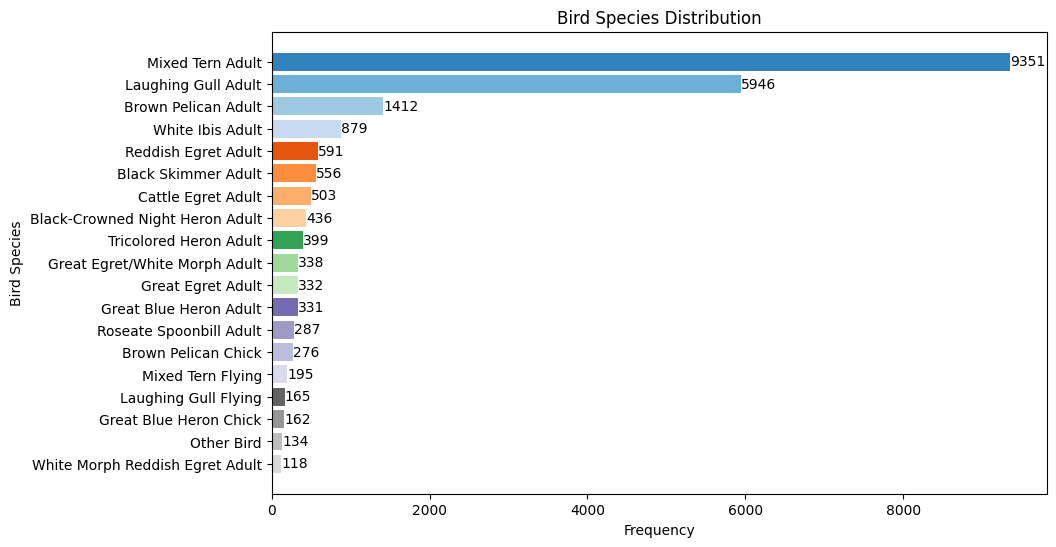

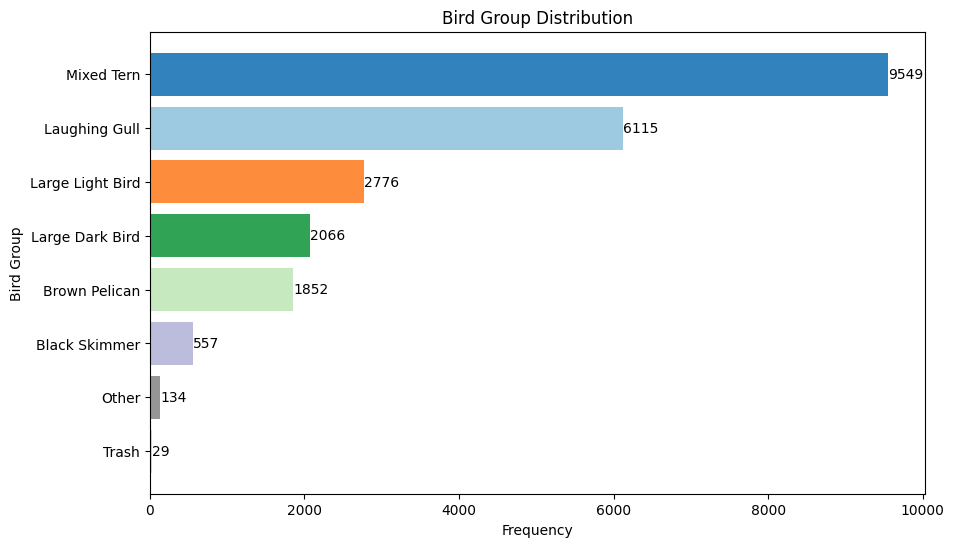

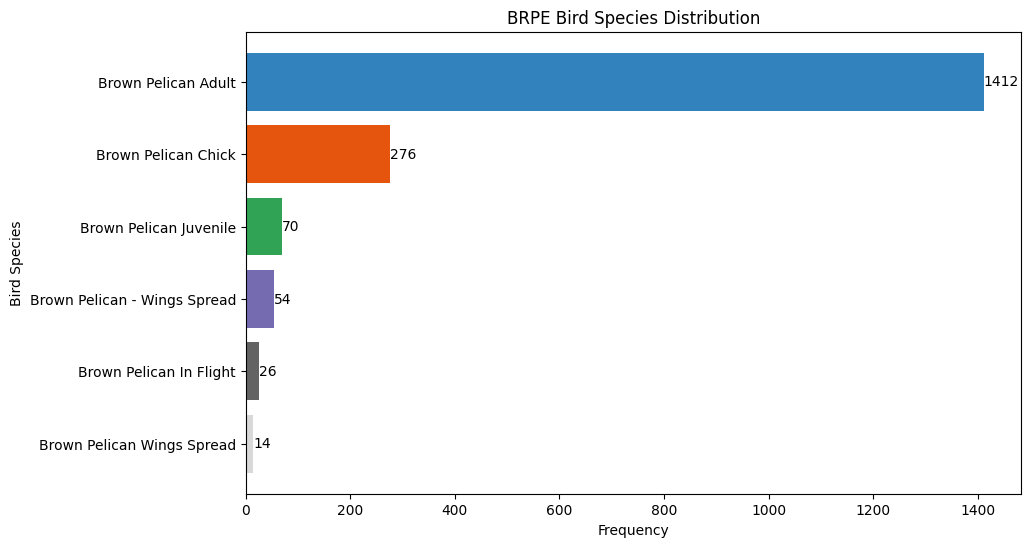

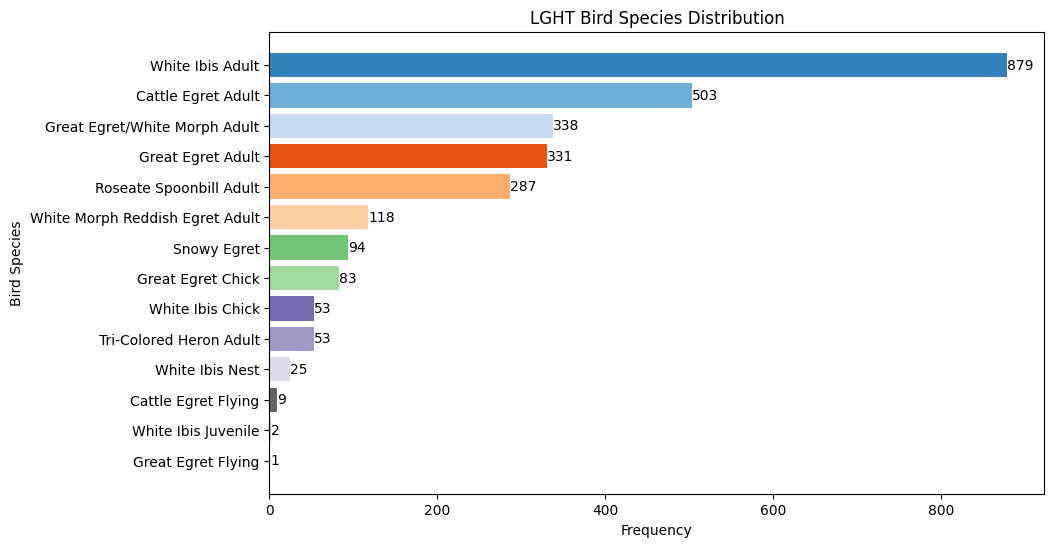

In [ ]:
# Make histograms for bird species classes and hierarchical groups. 
# We can also view species distributions within hierarchical groups.

def test_plot_distribution():
    ''' Test plot_distribution() ''' 
    # Plots are saved to 'plots' folder in working directory
    vis.plot_distribution(FRAMES['combined annotations'], "class_name", 
                          ("Frequency", "Bird Species", "Bird Species Distribution"), PLOTS_PATH, filt=100)
    vis.plot_distribution(FRAMES['combined annotations'], "group_name", 
                          ("Frequency", "Bird Group", "Bird Group Distribution"), PLOTS_PATH)
    vis.plot_distribution(FRAMES['combined annotations'].loc[FRAMES['combined annotations']['group_id'] == 'BRPE'], "class_name", 
                          ("Frequency", "Bird Species", "BRPE Bird Species Distribution"), PLOTS_PATH)
    vis.plot_distribution(FRAMES['combined annotations'].loc[FRAMES['combined annotations']['group_id'] == 'LGHT'], "class_name", 
                          ("Frequency", "Bird Species", "LGHT Bird Species Distribution"), PLOTS_PATH)            

test_plot_distribution()

In [ ]:
# Load a UAV image overlaid with annotation boxes. 

def test_plot_boxes():
    ''' Test plot_boxes() '''
    # Image is added to the 'plots' folder in working directory. 
    vis.plot_boxes(FILES['trainset']['jpg'][10], FILES['trainset']['csv'][10], 'Annotations', PLOTS_PATH, show=True)

test_plot_boxes()

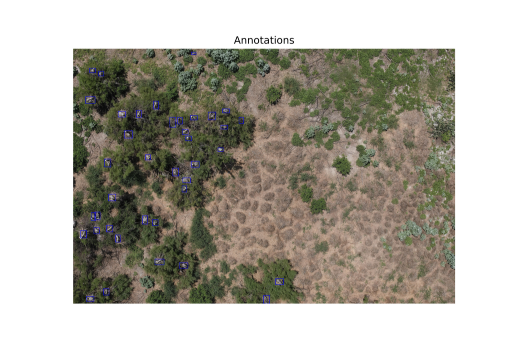

In [ ]:
# Preview of the annotated image (download image for best resolution)

image = plt.imread('./plots/Annotations.jpg')
plt.imshow(image)
plt.margins(x=0)
plt.axis('off')
plt.show()

## Part 4 - Train bird detection model

In [ ]:
# Load training and test sets in PyTorch (computer vision libary).

def test_get_bird_dataloaders():
    ''' Test get_bird_dataloaders() '''
    trainloader, testloader = get_bird_dataloaders(FILES['trainset'], FILES['testset'])
    DATALOADERS['trainset'] = trainloader
    DATALOADERS['testset'] = testloader

test_get_bird_dataloaders()

In [ ]:
# Create bird detection model using Faster-RCNN with a ResNet50 backbone network.

def test_get_detection_model():
    MODEL_OPTIM['faster rcnn'] = get_model_and_optim(choice='fasterrcnn_resnet50_fpn')

test_get_detection_model()

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [ ]:
# Train the model.

NUM_EPOCH = 100
def test_train_model():
    ''' Test train_model() '''
    train_model(MODEL_OPTIM['faster rcnn'][0], 
                          MODEL_OPTIM['faster rcnn'][1], 
                          DATALOADERS['trainset'], 
                          DATALOADERS['testset'], 
                          NUM_EPOCH, DEVICE)

test_train_model()

Epoch 1 of 100: 100%|███████████████████████████| 80/80 [01:30<00:00,  1.13s/it]


Epoch: 1 | Loss: tensor(111.7897, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 2 of 100: 100%|███████████████████████████| 80/80 [01:25<00:00,  1.07s/it]


Epoch: 2 | Loss: tensor(84.5268, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 3 of 100: 100%|███████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 3 | Loss: tensor(78.8034, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 4 of 100: 100%|███████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 4 | Loss: tensor(75.7340, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 5 of 100: 100%|███████████████████████████| 80/80 [01:26<00:00,  1.09s/it]


Epoch: 5 | Loss: tensor(69.8712, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 6 of 100: 100%|███████████████████████████| 80/80 [01:26<00:00,  1.09s/it]


Epoch: 6 | Loss: tensor(68.3339, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 7 of 100: 100%|███████████████████████████| 80/80 [01:27<00:00,  1.09s/it]


Epoch: 7 | Loss: tensor(66.6019, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 8 of 100: 100%|███████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 8 | Loss: tensor(66.2865, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 9 of 100: 100%|███████████████████████████| 80/80 [01:27<00:00,  1.09s/it]


Epoch: 9 | Loss: tensor(62.9980, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 10 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 10 | Loss: tensor(61.7287, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 11 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 11 | Loss: tensor(60.0516, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 12 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 12 | Loss: tensor(58.7213, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 13 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 13 | Loss: tensor(58.1758, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 14 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 14 | Loss: tensor(56.5876, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 15 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 15 | Loss: tensor(53.7676, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 16 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 16 | Loss: tensor(53.7336, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 17 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 17 | Loss: tensor(52.4874, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 18 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 18 | Loss: tensor(51.2156, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 19 of 100: 100%|██████████████████████████| 80/80 [01:25<00:00,  1.07s/it]


Epoch: 19 | Loss: tensor(51.2196, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 20 of 100: 100%|██████████████████████████| 80/80 [01:25<00:00,  1.07s/it]


Epoch: 20 | Loss: tensor(50.3503, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 21 of 100: 100%|██████████████████████████| 80/80 [01:25<00:00,  1.07s/it]


Epoch: 21 | Loss: tensor(48.2233, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 22 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 22 | Loss: tensor(47.8388, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 23 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 23 | Loss: tensor(46.4922, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 24 of 100: 100%|██████████████████████████| 80/80 [01:27<00:00,  1.09s/it]


Epoch: 24 | Loss: tensor(47.1722, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 25 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 25 | Loss: tensor(46.4219, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 26 of 100: 100%|██████████████████████████| 80/80 [01:25<00:00,  1.07s/it]


Epoch: 26 | Loss: tensor(44.6743, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 27 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 27 | Loss: tensor(42.4575, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 28 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.09s/it]


Epoch: 28 | Loss: tensor(43.2097, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 29 of 100: 100%|██████████████████████████| 80/80 [01:25<00:00,  1.07s/it]


Epoch: 29 | Loss: tensor(43.6972, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 30 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 30 | Loss: tensor(44.9094, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 31 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 31 | Loss: tensor(42.1660, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 32 of 100: 100%|██████████████████████████| 80/80 [01:25<00:00,  1.07s/it]


Epoch: 32 | Loss: tensor(41.0375, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 33 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 33 | Loss: tensor(39.6646, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 34 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 34 | Loss: tensor(38.9168, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 35 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 35 | Loss: tensor(40.4121, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 36 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 36 | Loss: tensor(39.6650, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 37 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 37 | Loss: tensor(39.6594, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 38 of 100: 100%|██████████████████████████| 80/80 [01:27<00:00,  1.09s/it]


Epoch: 38 | Loss: tensor(37.3740, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 39 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 39 | Loss: tensor(37.5687, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 40 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 40 | Loss: tensor(38.4594, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 41 of 100: 100%|██████████████████████████| 80/80 [01:28<00:00,  1.10s/it]


Epoch: 41 | Loss: tensor(36.7740, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 42 of 100: 100%|██████████████████████████| 80/80 [01:27<00:00,  1.09s/it]


Epoch: 42 | Loss: tensor(35.0868, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 43 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 43 | Loss: tensor(35.7671, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 44 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 44 | Loss: tensor(35.1776, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 45 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.09s/it]


Epoch: 45 | Loss: tensor(34.6583, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 46 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 46 | Loss: tensor(33.4721, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 47 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 47 | Loss: tensor(33.2714, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 48 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 48 | Loss: tensor(35.6419, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 49 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 49 | Loss: tensor(34.4137, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 50 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 50 | Loss: tensor(33.7107, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 51 of 100: 100%|██████████████████████████| 80/80 [01:27<00:00,  1.09s/it]


Epoch: 51 | Loss: tensor(31.9625, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 52 of 100: 100%|██████████████████████████| 80/80 [01:27<00:00,  1.09s/it]


Epoch: 52 | Loss: tensor(32.3478, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 53 of 100: 100%|██████████████████████████| 80/80 [01:25<00:00,  1.07s/it]


Epoch: 53 | Loss: tensor(32.1632, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 54 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 54 | Loss: tensor(30.6202, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 55 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 55 | Loss: tensor(30.7601, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 56 of 100: 100%|██████████████████████████| 80/80 [01:27<00:00,  1.10s/it]


Epoch: 56 | Loss: tensor(30.4755, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 57 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 57 | Loss: tensor(30.0402, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 58 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 58 | Loss: tensor(29.0656, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 59 of 100: 100%|██████████████████████████| 80/80 [01:27<00:00,  1.09s/it]


Epoch: 59 | Loss: tensor(28.6950, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 60 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 60 | Loss: tensor(29.2921, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 61 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 61 | Loss: tensor(31.6376, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 62 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 62 | Loss: tensor(28.9829, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 63 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 63 | Loss: tensor(28.7827, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 64 of 100: 100%|██████████████████████████| 80/80 [01:27<00:00,  1.09s/it]


Epoch: 64 | Loss: tensor(28.3466, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 65 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 65 | Loss: tensor(27.8424, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 66 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 66 | Loss: tensor(27.3170, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 67 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.09s/it]


Epoch: 67 | Loss: tensor(27.4045, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 68 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.09s/it]


Epoch: 68 | Loss: tensor(27.2678, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 69 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 69 | Loss: tensor(25.9704, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 70 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 70 | Loss: tensor(27.4664, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 71 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 71 | Loss: tensor(25.8461, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 72 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 72 | Loss: tensor(25.4054, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 73 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.09s/it]


Epoch: 73 | Loss: tensor(26.0668, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 74 of 100: 100%|██████████████████████████| 80/80 [01:25<00:00,  1.07s/it]


Epoch: 74 | Loss: tensor(26.7809, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 75 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 75 | Loss: tensor(27.2192, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 76 of 100: 100%|██████████████████████████| 80/80 [01:25<00:00,  1.07s/it]


Epoch: 76 | Loss: tensor(24.3777, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 77 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 77 | Loss: tensor(24.8446, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 78 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 78 | Loss: tensor(24.9493, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 79 of 100: 100%|██████████████████████████| 80/80 [01:27<00:00,  1.09s/it]


Epoch: 79 | Loss: tensor(25.2012, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 80 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 80 | Loss: tensor(26.4758, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 81 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.09s/it]


Epoch: 81 | Loss: tensor(25.4051, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 82 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 82 | Loss: tensor(25.3364, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 83 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 83 | Loss: tensor(23.9702, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 84 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.09s/it]


Epoch: 84 | Loss: tensor(24.8744, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 85 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 85 | Loss: tensor(23.1114, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 86 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 86 | Loss: tensor(23.6429, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 87 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 87 | Loss: tensor(23.4712, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 88 of 100: 100%|██████████████████████████| 80/80 [01:27<00:00,  1.10s/it]


Epoch: 88 | Loss: tensor(22.9451, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 89 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 89 | Loss: tensor(24.9735, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 90 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 90 | Loss: tensor(22.3457, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 91 of 100: 100%|██████████████████████████| 80/80 [01:27<00:00,  1.09s/it]


Epoch: 91 | Loss: tensor(23.4149, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 92 of 100: 100%|██████████████████████████| 80/80 [01:27<00:00,  1.09s/it]


Epoch: 92 | Loss: tensor(23.9241, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 93 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 93 | Loss: tensor(24.6848, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 94 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 94 | Loss: tensor(22.5492, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 95 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 95 | Loss: tensor(22.0664, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 96 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 96 | Loss: tensor(21.0061, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 97 of 100: 100%|██████████████████████████| 80/80 [01:25<00:00,  1.07s/it]


Epoch: 97 | Loss: tensor(21.3666, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 98 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 98 | Loss: tensor(22.5114, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 99 of 100: 100%|██████████████████████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch: 99 | Loss: tensor(21.5243, device='cuda:0', grad_fn=<AddBackward0>)



Epoch 100 of 100: 100%|█████████████████████████| 80/80 [01:25<00:00,  1.07s/it]

Epoch: 100 | Loss: tensor(21.9734, device='cuda:0', grad_fn=<AddBackward0>)

